# Install Required Libraries

In [1]:
!pip install rasterio albumentations segmentation-models

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 63.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 4.3 MB/s eta 0:00:00


# Import Libraries

In [2]:
import os
import zipfile
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import rasterio   # for loading the 12 spectral band images
from PIL import Image
import albumentations as A

In [3]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, BatchNormalization, Activation
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.metrics import MeanIoU

In [4]:
# import segmentation_models as sm

In [5]:
print("TF Version: ", tf.__version__)
print("keras version: ", keras.__version__)

TF Version:  2.19.0
keras version:  3.10.0


# Mount Google Drive

In [6]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


# Extract Zip File

In [7]:
zip_path = '/content/drive/MyDrive/Colab Notebooks/Cellula Tech Intern Computer Vision/Task 3: Satellite Images Flooding Segmentation/satalite data-20250918T154859Z-1-001.zip'
extract_path = '/content/satellite_dataset/'

In [8]:
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Define Paths

In [9]:
data_path = os.path.join(extract_path, 'satalite data/data')
images_path = os.path.join(data_path, 'images')
labels_path = os.path.join(data_path, 'labels')

# Function to Match Images and Masks

In [10]:
def get_matched_files(images_path, labels_path):
    image_files = [f for f in os.listdir(images_path) if f.endswith('.tif')]
    matched_images = []
    matched_masks = []

    for img_file in image_files:
        base_name = os.path.splitext(img_file)[0]
        mask_file = f"{base_name}.png"
        mask_path = os.path.join(labels_path, mask_file)

        if os.path.exists(mask_path):
            matched_images.append(os.path.join(images_path, img_file))
            matched_masks.append(mask_path)

    return matched_images, matched_masks

In [11]:
matched_images, matched_masks = get_matched_files(images_path, labels_path)
print(f"Found {len(matched_images)} matched pairs.")

Found 306 matched pairs.


# Function to Load Image (Multi-band TIFF)

In [12]:
def load_image(file_path):
    with rasterio.open(file_path) as src:
        image = src.read()  # Shape: (bands, height, width)
        image = np.moveaxis(image, 0, -1)  # Shape: (height, width, bands)
    return image.astype(np.float32)

# Function to Load Mask (Binary PNG)

In [13]:
def load_mask(file_path):
    mask = np.array(Image.open(file_path))
    mask = np.expand_dims(mask, axis=-1)  # Add channel dimension
    mask = (mask > 0).astype(np.float32)  # Ensure binary
    return mask

# Load Dataset

In [14]:
images = []
masks = []

for img_path, mask_path in zip(matched_images, matched_masks):
    img = load_image(img_path)
    msk = load_mask(mask_path)
    if img.shape == (128, 128, 12) and msk.shape == (128, 128, 1):
        images.append(img)
        masks.append(msk)

images = np.array(images)
masks = np.array(masks)

print(f"Loaded {len(images)} images and masks.")

/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Loaded 306 images and masks.


# Normalization with Min-Max Scaler (Per Band)

In [15]:
def normalize_images(images):
    normalized_images = np.zeros_like(images)
    for i in range(images.shape[0]):
        for band in range(12):
            scaler = MinMaxScaler()
            band_data = images[i, :, :, band].reshape(-1, 1)
            normalized_band = scaler.fit_transform(band_data).reshape(128, 128)
            normalized_images[i, :, :, band] = normalized_band
    return normalized_images

In [16]:
images = normalize_images(images)

# Compute Class Weights for Imbalance  (added for better results)

In [17]:
def compute_class_weights(masks):
    total_pixels = masks.size
    water_pixels = np.sum(masks)
    non_water_pixels = total_pixels - water_pixels
    if water_pixels == 0 or non_water_pixels == 0:
        return 1.0
    weight_water = total_pixels / (2 * water_pixels)
    weight_non_water = total_pixels / (2 * non_water_pixels)
    return [weight_non_water, weight_water]

class_weights = compute_class_weights(masks)
print(f"Class weights: {class_weights}")

Class weights: [np.float32(0.6754501), np.float32(1.9249066)]


# Data Augmentation with Albumentations

In [18]:
# def get_augmentation():
#     return A.Compose([
#         A.HorizontalFlip(p=0.5),
#         A.VerticalFlip(p=0.5),
#         A.RandomRotate90(p=0.5),
#         A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=30, p=0.5),
#         A.RandomBrightnessContrast(p=0.5),
#     ])

In [19]:
def get_augmentation():
    return A.Compose([
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomRotate90(p=0.5),
        A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=30, p=0.5),
        A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
        A.GridDistortion(p=0.5),
        A.ElasticTransform(p=0.5),
    ])

# Function to Apply Augmentation

In [20]:
# def augment_data(images, masks, augmentation):
#     augmented_images = []
#     augmented_masks = []
#     for img, msk in zip(images, masks):
#         augmented = augmentation(image=img, mask=msk)
#         augmented_images.append(augmented['image'])
#         augmented_masks.append(augmented['mask'])
#     return np.array(augmented_images), np.array(augmented_masks)

In [21]:
# augmentation = get_augmentation()
# aug_images, aug_masks = augment_data(images, masks, augmentation)

In [22]:
def augment_data(images, masks, augmentation, num_augs=1):
    augmented_images = []
    augmented_masks = []
    for _ in range(num_augs):
        for img, msk in zip(images, masks):
            augmented = augmentation(image=img, mask=msk)
            augmented_images.append(augmented['image'])
            augmented_masks.append(augmented['mask'])
    return np.array(augmented_images), np.array(augmented_masks)

In [23]:
augmentation = get_augmentation()
aug_images, aug_masks = augment_data(images, masks, augmentation, num_augs=2)  # Double the augmentations

/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


# Combine Original and Augmented Data

In [24]:
all_images = np.concatenate([images, aug_images], axis=0)
all_masks = np.concatenate([masks, aug_masks], axis=0)

# Train-Test Split

In [25]:
X_train, X_test, y_train, y_test = train_test_split(all_images, all_masks, test_size=0.2, random_state=42)

# Function to Visualize Random Images in RGB Format

In [26]:
def visualize_random_rgb(images, num_samples=3):
    indices = np.random.choice(len(images), num_samples, replace=False)
    fig, axs = plt.subplots(1, num_samples, figsize=(15, 5))

    for idx, ax in zip(indices, axs):
        # Use bands 3 (Red), 2 (Green), 1 (Blue) for RGB approximation
        rgb = images[idx][:, :, [3, 2, 1]]
        rgb = np.clip(rgb, 0, 1)  # Normalize to [0, 1]
        ax.imshow(rgb)
        ax.set_title(f'Image {idx} (RGB approx)')
        ax.axis('off')

    plt.tight_layout()
    plt.show()

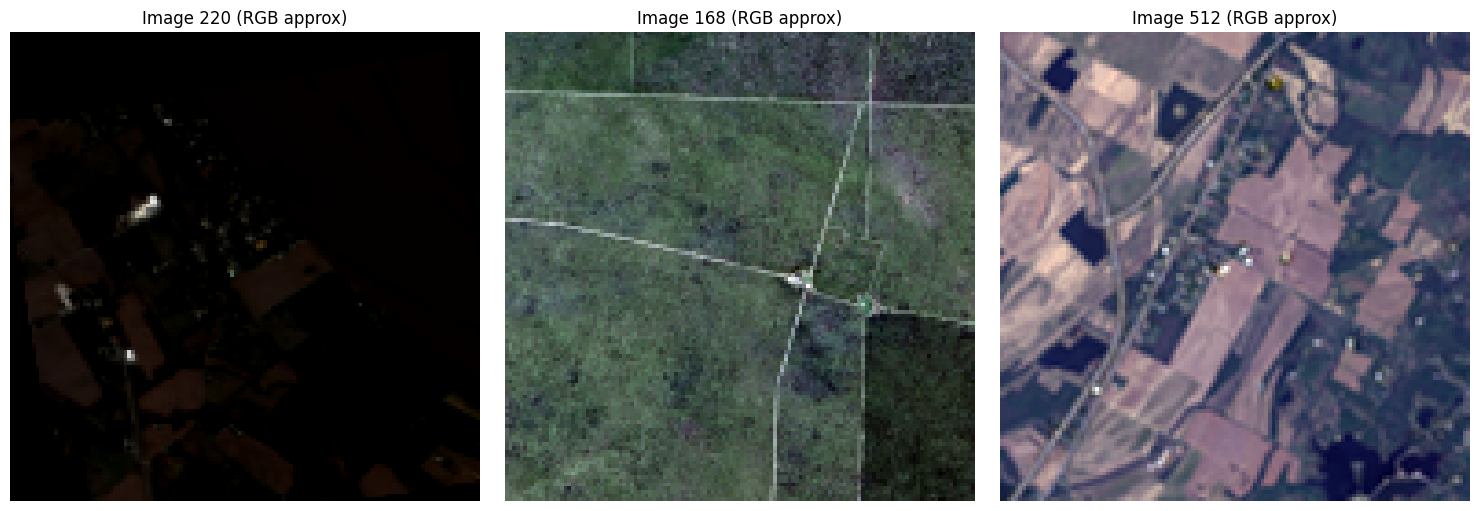

In [27]:
visualize_random_rgb(X_train)

# Visualization: Show Bands of One Image

In [28]:
def visualize_bands(image, band_names=None):
    if band_names is None:
        band_names = [
            'Coastal Aerosol', 'Blue', 'Green', 'Red', 'NIR', 'SWIR1', 'SWIR2', 'QA Band',
            'Merit DEM', 'Copernicus DEM', 'ESA World Cover', 'Water Occurrence'
        ]

    fig, axs = plt.subplots(3, 4, figsize=(20, 15))
    axs = axs.ravel()

    for i in range(12):
        axs[i].imshow(image[:, :, i], cmap='gray')
        axs[i].set_title(band_names[i])
        axs[i].axis('off')

    plt.tight_layout()
    plt.show()

# Visualize first image bands

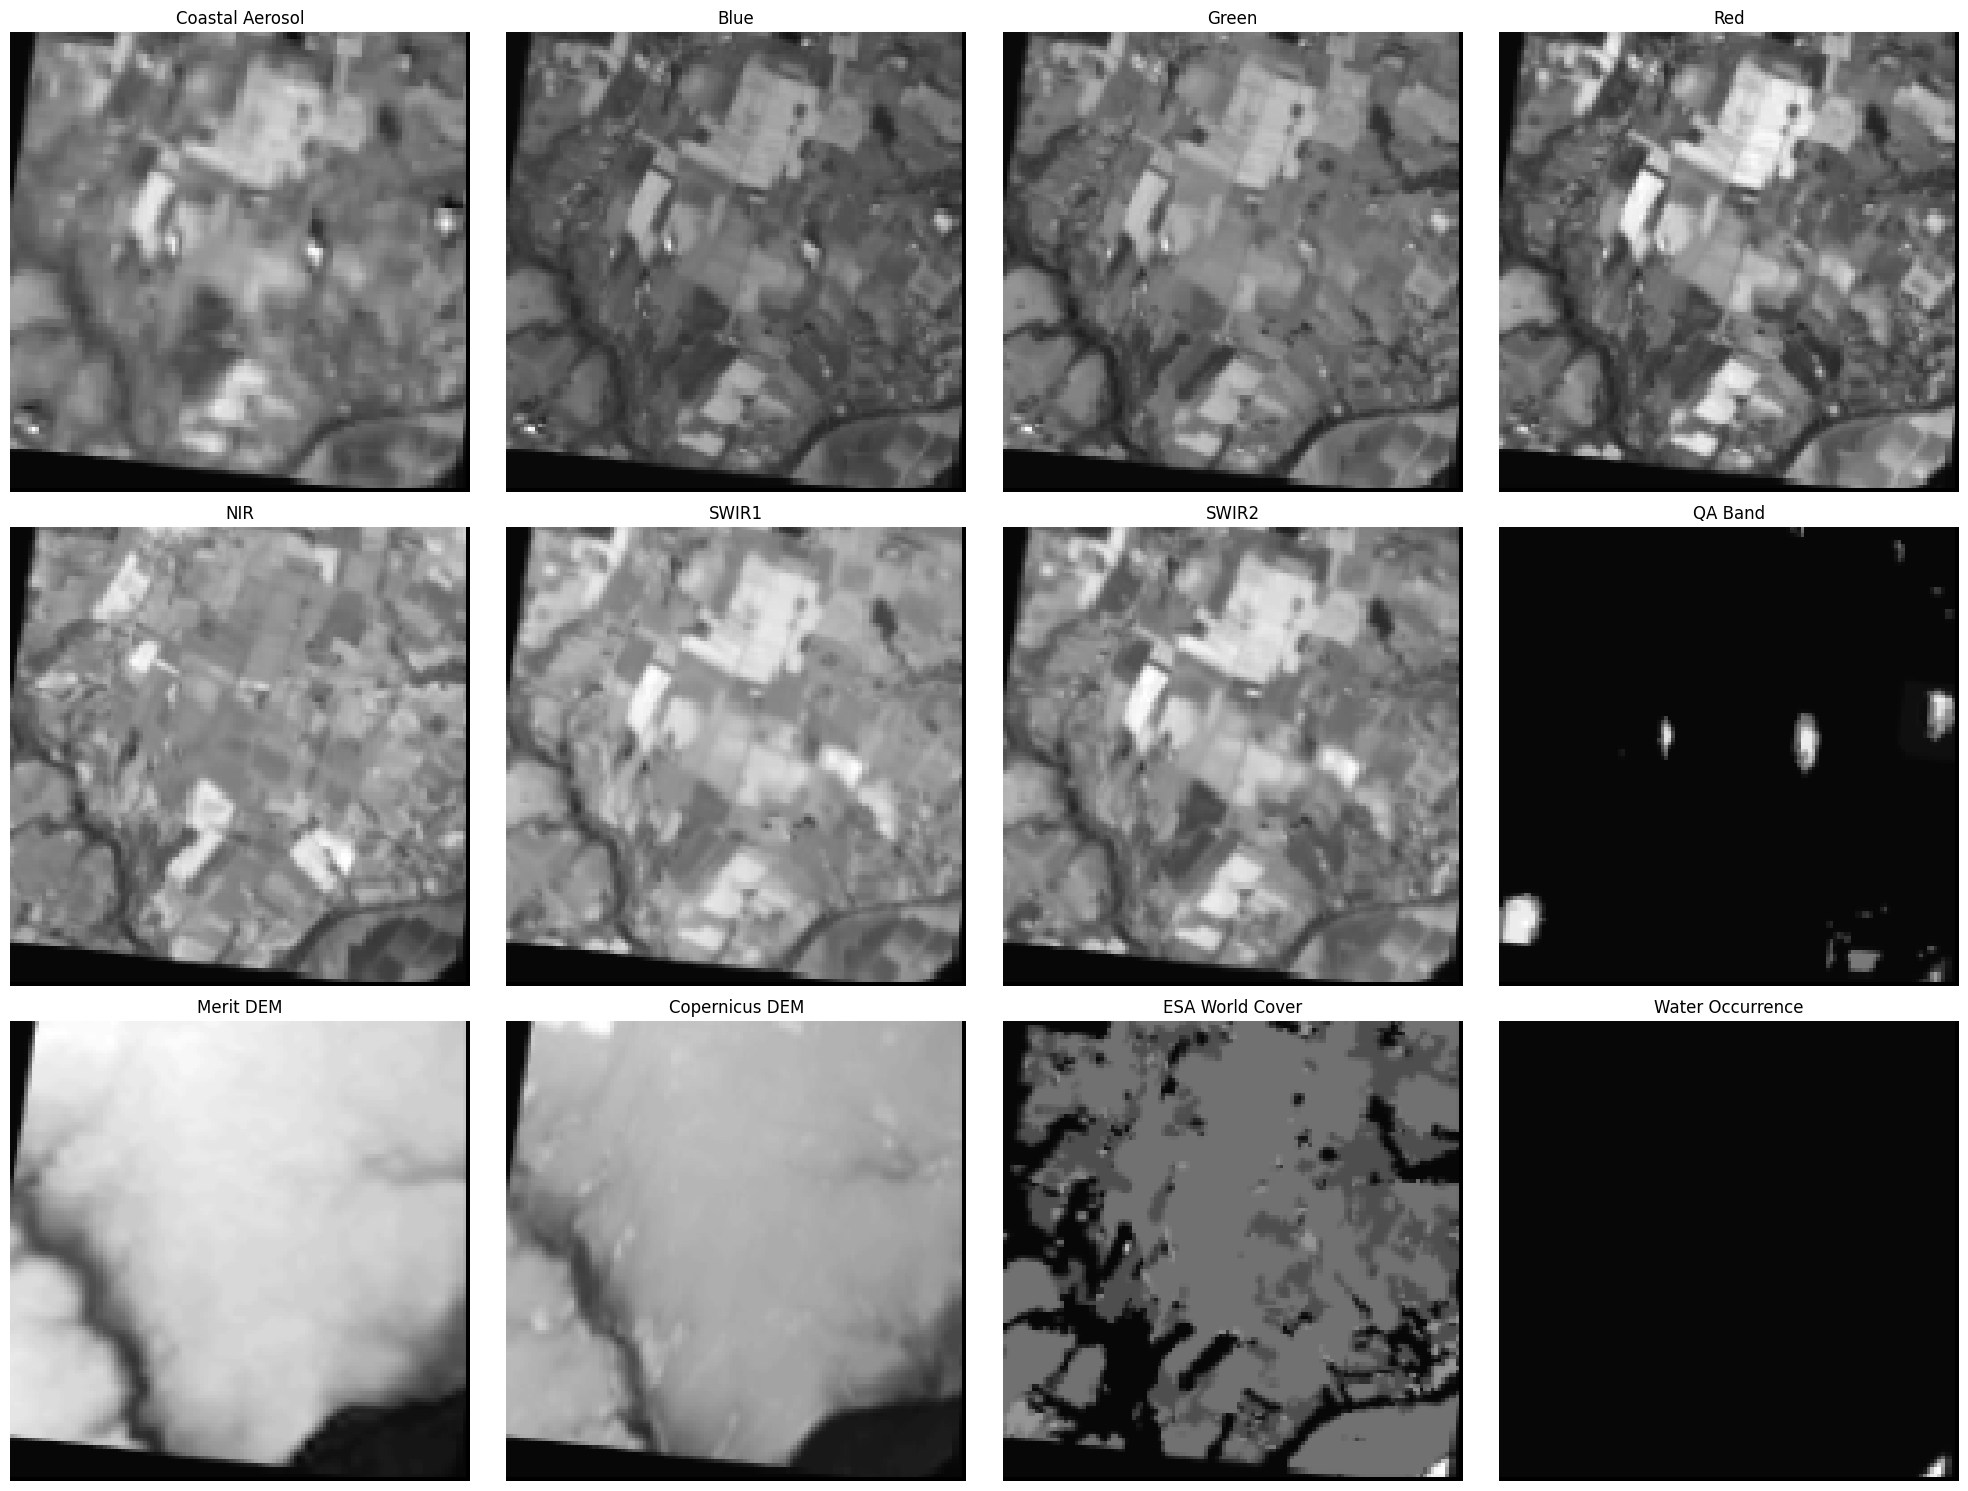

In [29]:
visualize_bands(X_train[0])

# U-Net Model Function

In [30]:
# def unet_model(input_size=(128, 128, 12)):
#     inputs = Input(input_size)

#     # Encoder
#     c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
#     c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
#     p1 = MaxPooling2D((2, 2))(c1)

#     c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
#     c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
#     p2 = MaxPooling2D((2, 2))(c2)

#     c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
#     c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
#     p3 = MaxPooling2D((2, 2))(c3)

#     c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
#     c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
#     p4 = MaxPooling2D((2, 2))(c4)

#     # bottleneck
#     c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
#     c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)

#     # Decoder
#     u6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
#     u6 = concatenate([u6, c4])
#     c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
#     c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

#     u7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
#     u7 = concatenate([u7, c3])
#     c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
#     c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

#     u8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
#     u8 = concatenate([u8, c2])
#     c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
#     c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

#     u9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
#     u9 = concatenate([u9, c1])
#     c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
#     c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

#     outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

#     model = Model(inputs=inputs, outputs=outputs)
#     return model

In [31]:
def unet_model(input_size=(128, 128, 12)):
    inputs = Input(input_size)

    # Encoder
    c1 = Conv2D(64, (3, 3), padding='same')(inputs)
    c1 = BatchNormalization()(c1)
    c1 = Activation("relu")(c1)

    c1 = Conv2D(64, (3, 3), padding='same')(c1)
    c1 = BatchNormalization()(c1)
    c1 = Activation("relu")(c1)

    c1 = Conv2D(64, (3, 3), padding='same')(c1)
    c1 = BatchNormalization()(c1)
    c1 = Activation("relu")(c1)

    p1 = MaxPooling2D((2, 2))(c1)


    c2 = Conv2D(128, (3, 3), padding='same')(p1)
    c2 = BatchNormalization()(c2)
    c2 = Activation("relu")(c2)

    c2 = Conv2D(128, (3, 3), padding='same')(c2)
    c2 = BatchNormalization()(c2)
    c2 = Activation("relu")(c2)

    c2 = Conv2D(128, (3, 3), padding='same')(c2)
    c2 = BatchNormalization()(c2)
    c2 = Activation("relu")(c2)

    p2 = MaxPooling2D((2, 2))(c2)


    c3 = Conv2D(256, (3, 3), padding='same')(p2)
    c3 = BatchNormalization()(c3)
    c3 = Activation("relu")(c3)

    c3 = Conv2D(256, (3, 3), padding='same')(c3)
    c3 = BatchNormalization()(c3)
    c3 = Activation("relu")(c3)

    c3 = Conv2D(256, (3, 3), padding='same')(c3)
    c3 = BatchNormalization()(c3)
    c3 = Activation("relu")(c3)

    p3 = MaxPooling2D((2, 2))(c3)


    c4 = Conv2D(512, (3, 3), padding='same')(p3)
    c4 = BatchNormalization()(c4)
    c4 = Activation("relu")(c4)

    c4 = Conv2D(512, (3, 3), padding='same')(c4)
    c4 = BatchNormalization()(c4)
    c4 = Activation("relu")(c4)

    c4 = Conv2D(512, (3, 3), padding='same')(c4)
    c4 = BatchNormalization()(c4)
    c4 = Activation("relu")(c4)

    p4 = MaxPooling2D((2, 2))(c4)


    # Bottleneck
    c5 = Conv2D(1024, (3, 3), padding='same')(p4)
    c5 = BatchNormalization()(c5)
    c5 = Activation("relu")(c5)

    c5 = Conv2D(1024, (3, 3), padding='same')(c5)
    c5 = BatchNormalization()(c5)
    c5 = Activation("relu")(c5)

    c5 = Conv2D(1024, (3, 3), padding='same')(c5)
    c5 = BatchNormalization()(c5)
    c5 = Activation("relu")(c5)

    # Decoder
    u6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])

    c6 = Conv2D(512, (3, 3), padding='same')(u6)
    c6 = BatchNormalization()(c6)
    c6 = Activation("relu")(c6)

    c6 = Conv2D(512, (3, 3), padding='same')(c6)
    c6 = BatchNormalization()(c6)
    c6 = Activation("relu")(c6)

    c6 = Conv2D(512, (3, 3), padding='same')(c6)
    c6 = BatchNormalization()(c6)
    c6 = Activation("relu")(c6)


    u7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])

    c7 = Conv2D(256, (3, 3), padding='same')(u7)
    c7 = BatchNormalization()(c7)
    c7 = Activation("relu")(c7)

    c7 = Conv2D(256, (3, 3), padding='same')(c7)
    c7 = BatchNormalization()(c7)
    c7 = Activation("relu")(c7)

    c7 = Conv2D(256, (3, 3), padding='same')(c7)
    c7 = BatchNormalization()(c7)
    c7 = Activation("relu")(c7)


    u8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])

    c8 = Conv2D(128, (3, 3), padding='same')(u8)
    c8 = BatchNormalization()(c8)
    c8 = Activation("relu")(c8)

    c8 = Conv2D(128, (3, 3), padding='same')(c8)
    c8 = BatchNormalization()(c8)
    c8 = Activation("relu")(c8)

    c8 = Conv2D(128, (3, 3), padding='same')(c8)
    c8 = BatchNormalization()(c8)
    c8 = Activation("relu")(c8)


    u9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1])

    c9 = Conv2D(64, (3, 3), padding='same')(u9)
    c9 = BatchNormalization()(c9)
    c9 = Activation("relu")(c9)

    c9 = Conv2D(64, (3, 3), padding='same')(c9)
    c9 = BatchNormalization()(c9)
    c9 = Activation("relu")(c9)

    c9 = Conv2D(64, (3, 3), padding='same')(c9)
    c9 = BatchNormalization()(c9)
    c9 = Activation("relu")(c9)

    # Output Layer
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs=inputs, outputs=outputs)
    return model

# Instantiate and Compile Model

In [32]:
nn_model = unet_model(input_size=(128, 128, 12))
nn_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 12)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │      6,976 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128, 128,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │     36,928 │ activation[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     36,928 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │    147,584 │ activation_3[0][… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 64, 64,    │          0 │ batch_normalizat

 Total params: 46,779,265 (178.45 MB)

 Trainable params: 46,761,601 (178.38 MB)

 Non-trainable params: 17,664 (69.00 KB)

In [41]:
# Define callbacks
nn_model_callbacks = [
    # ModelCheckpoint to save the best model based on validation IoU
    ModelCheckpoint('best_unet_model.keras', monitor='val_mean_io_u_1', save_best_only=True, mode='max', verbose=1),

    # ReduceLROnPlateau to reduce learning rate when validation IoU plateaus
    ReduceLROnPlateau(monitor='val_mean_io_u_1',
                      factor=0.5, # Factor by which the learning rate will be reduced. new_lr = lr * factor
                      patience=2, # Number of epochs with no improvement after which the learning rate will be reduced.
                      mode='max',
                      min_lr=0.000001, # Lower bound on the learning rate (1e-6).
                      verbose=1)
]

In [38]:
LR = 1e-4
BATCH_SIZE = 32
EPOCHS = 100

# loss = sm.losses.DiceLoss(class_weights=np.array(class_weights))
# metrics = [sm.metrics.IOUScore(class_weights=np.array(class_weights)), 'accuracy']

In [39]:
nn_model.compile(optimizer=Adam(learning_rate=LR), loss='binary_crossentropy',
                 metrics=['accuracy', MeanIoU(num_classes=2)])

# Train Model

In [42]:
print("Model is Fitting...")

nn_model_fit = nn_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks = nn_model_callbacks
)

# callbacks=[checkpoint, early_stop]

Model is Fitting...
Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 627ms/step - accuracy: 0.9172 - loss: 0.2145 - mean_io_u_1: 0.4014
Epoch 1: val_mean_io_u_1 improved from -inf to 0.36736, saving model to best_unet_model.keras
23/23 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.9172 - loss: 0.2146 - mean_io_u_1: 0.4013 - val_accuracy: 0.7347 - val_loss: 0.5548 - val_mean_io_u_1: 0.3674 - learning_rate: 1.0000e-04
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 613ms/step - accuracy: 0.9207 - loss: 0.2104 - mean_io_u_1: 0.4156
Epoch 2: val_mean_io_u_1 did not improve from 0.36736
23/23 ━━━━━━━━━━━━━━━━━━━━ 16s 675ms/step - accuracy: 0.9207 - loss: 0.2102 - mean_io_u_1: 0.4152 - val_accuracy: 0.7347 - val_loss: 0.5730 - val_mean_io_u_1: 0.3674 - learning_rate: 1.0000e-04
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 627ms/step - accuracy: 0.9178 - loss: 0.2083 - mean_io_u_1: 0.3989
Epoch 3: val_mean_io_u_1 did not improve from 0.36736

Epoch 3: ReduceLROnPlateau reducing learning rate to 4.9999998736

### Notes:

* It peaked at epoch 40 with `val_mean_io_u_1` = **0.4214**, `min lr` = **1e-6** with `accuracy` of **94%** and `val_accuracy` of **93%**

* It improved slightly at epoch 89 with `val_mean_io_u_1` = **0.40245**, `min lr` = **1e-6** with `accuracy` of **95%** and `val_accuracy` of **93%**

# Visualize Curves

In [49]:
def plot_accuracy_curves(model):
    plt.figure()
    plt.plot(model.history['accuracy'], label='train_acc')
    plt.plot(model.history['val_accuracy'], label='val_acc')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.tight_layout()
    plt.show()

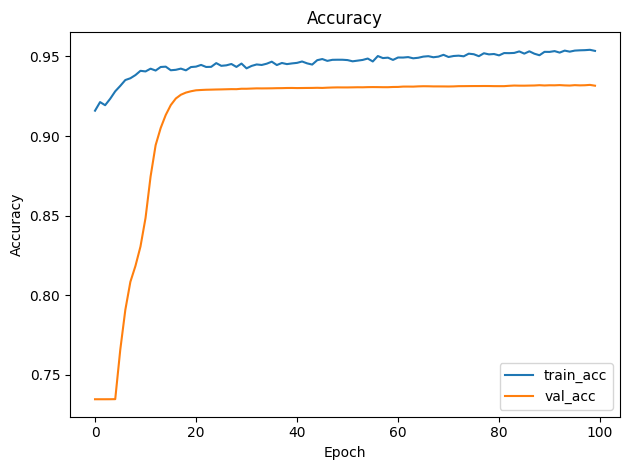

In [50]:
plot_accuracy_curves(nn_model_fit)

In [51]:
def plot_losses_curves(model):
    plt.figure()
    plt.plot(model.history['loss'], label='train_loss')
    plt.plot(model.history['val_loss'], label='val_loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()

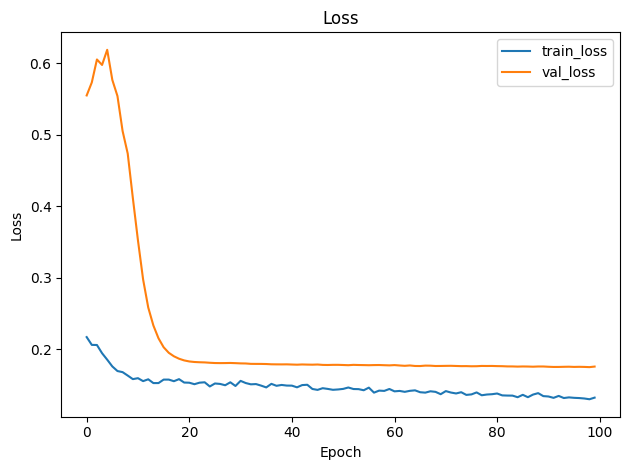

In [52]:
plot_losses_curves(nn_model_fit)

# Evaluate Model

In [43]:
def evaluate_model(model, X_test, y_test):
    loss, accuracy, iou = model.evaluate(X_test, y_test)
    print(f"Test Loss: {loss}")
    print(f"Test Accuracy: {accuracy}")
    print(f"Test IoU: {iou}")

    # Custom metrics for water class
    y_pred = model.predict(X_test)
    y_pred_bin = (y_pred > 0.5).astype(np.float32)

    intersection = np.sum(y_test * y_pred_bin)
    union = np.sum(y_test) + np.sum(y_pred_bin) - intersection
    iou_water = intersection / union if union != 0 else 0

    precision = intersection / np.sum(y_pred_bin) if np.sum(y_pred_bin) != 0 else 0
    recall = intersection / np.sum(y_test) if np.sum(y_test) != 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

    print(f"Water IoU: {iou_water}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1-Score: {f1}")

In [44]:
evaluate_model(nn_model, X_test, y_test)

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 221ms/step - accuracy: 0.9297 - loss: 0.1792 - mean_io_u_1: 0.3952
Test Loss: 0.17605435848236084
Test Accuracy: 0.9315772652626038
Test IoU: 0.3943735957145691
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 600ms/step
Water IoU: 0.7645305395126343
Precision: 0.8977274298667908
Recall: 0.8374730348587036
F1-Score: 0.8665541410446167


# Visualize Predictions

In [47]:
def visualize_predictions(model, X_test, y_test, num_samples=3):
    y_pred = model.predict(X_test[:num_samples])
    y_pred_bin = (y_pred > 0.5).astype(np.float32)

    for i in range(num_samples):
        fig, axs = plt.subplots(1, 3, figsize=(15, 5))

        # Show RGB approximation (bands 3,2,1 for Red,Green,Blue)
        rgb = X_test[i][:, :, [3, 2, 1]]  # Adjust if band indices differ
        rgb = np.clip(rgb, 0, 1)  # Since normalized
        axs[0].imshow(rgb)
        axs[0].set_title('Input Image (RGB approx)')
        axs[0].axis('off')

        axs[1].imshow(y_test[i].squeeze(), cmap='gray')
        axs[1].set_title('Ground Truth Mask')
        axs[1].axis('off')

        axs[2].imshow(y_pred_bin[i].squeeze(), cmap='gray')
        axs[2].set_title('Predicted Mask')
        axs[2].axis('off')

        plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


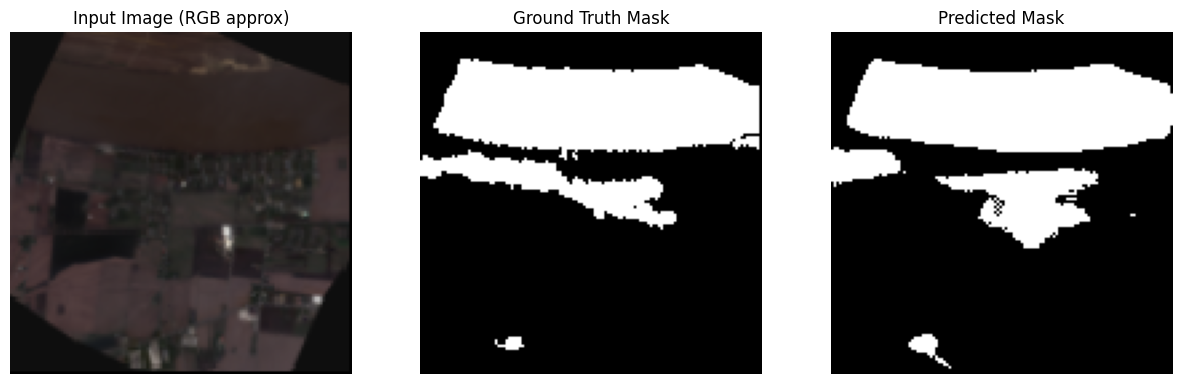

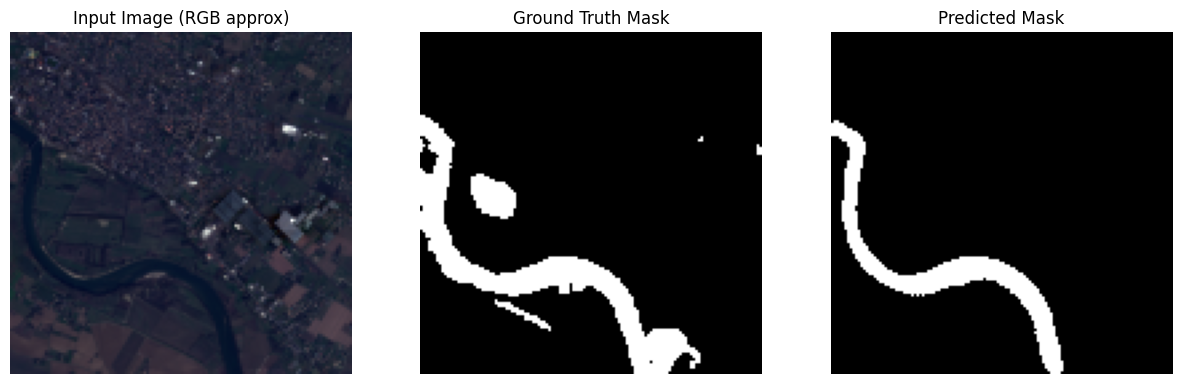

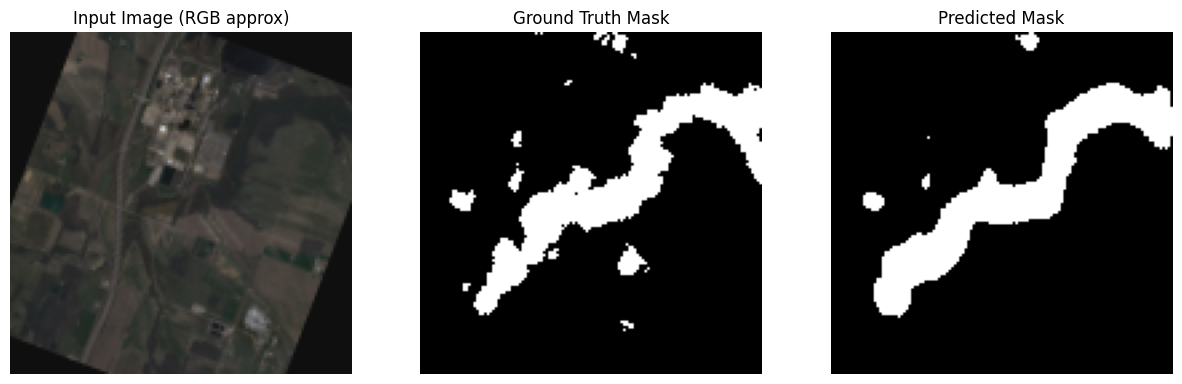

In [48]:
visualize_predictions(nn_model, X_test, y_test)

In [55]:
def visualize_predictions_blue(model, X_test, y_test, num_samples=3):
    y_pred = model.predict(X_test[:num_samples])
    y_pred_bin = (y_pred > 0.5).astype(np.float32)

    for i in range(num_samples):
        fig, axs = plt.subplots(1, 3, figsize=(15, 5))

        # Show RGB approximation (bands 3,2,1 for Red,Green,Blue)
        rgb = X_test[i][:, :, [3, 2, 1]]  # Adjust if band indices differ
        rgb = np.clip(rgb, 0, 1)  # Since normalized
        axs[0].imshow(rgb)
        axs[0].set_title('Input Image (RGB approx)')
        axs[0].axis('off')

        # Color ground truth mask: blue for water, black for non-water
        gt_mask_colored = np.zeros((*y_test[i].shape[:-1], 3))
        gt_mask_colored[y_test[i].squeeze() == 1] = [0, 0, 1]  # Blue RGB for water
        axs[1].imshow(gt_mask_colored)
        axs[1].set_title('Ground Truth Mask')
        axs[1].axis('off')

        # Color predicted mask: blue for water, black for non-water
        pred_mask_colored = np.zeros((*y_pred_bin[i].shape[:-1], 3))
        pred_mask_colored[y_pred_bin[i].squeeze() == 1] = [0, 0, 1]  # Blue RGB for water
        axs[2].imshow(pred_mask_colored)
        axs[2].set_title('Predicted Mask')
        axs[2].axis('off')

        plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


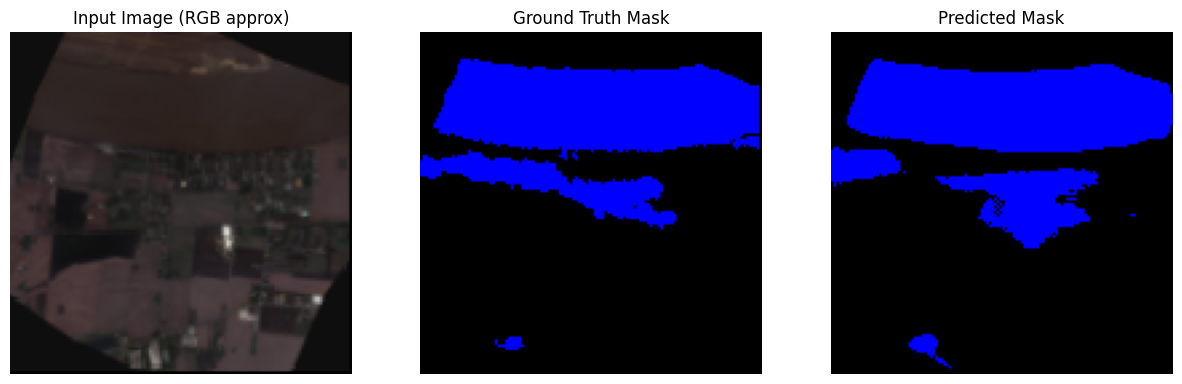

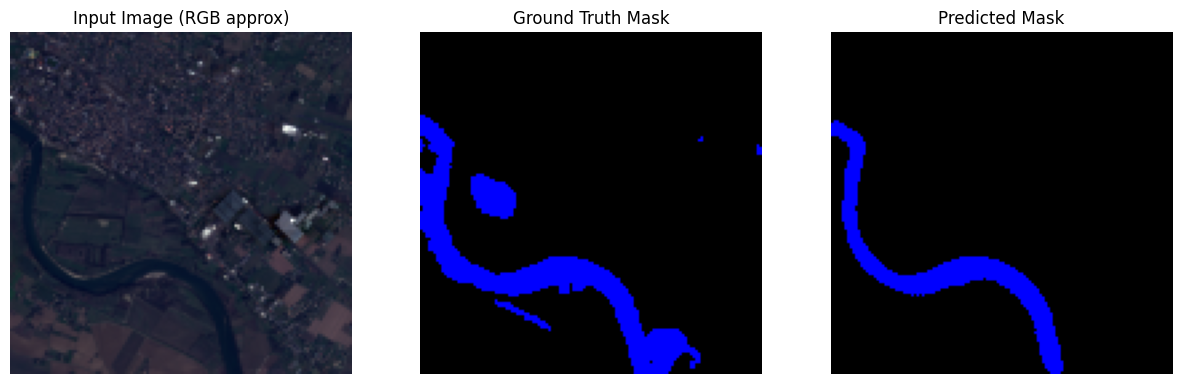

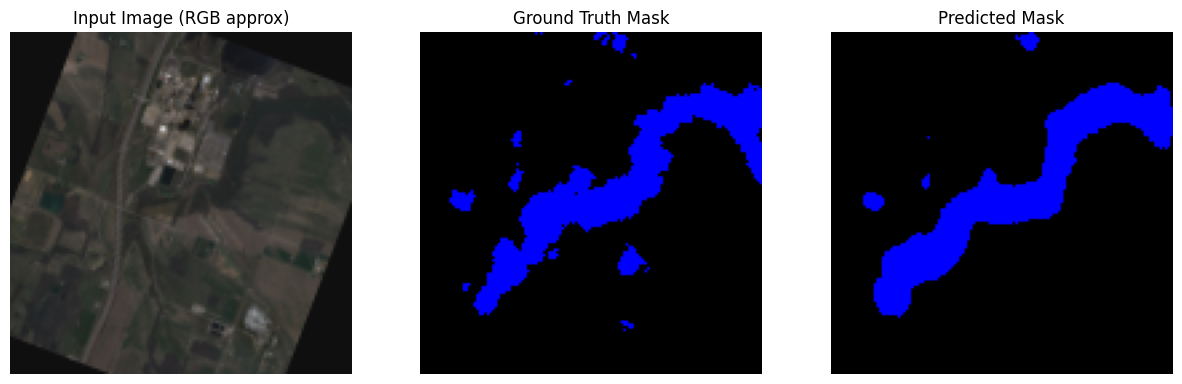

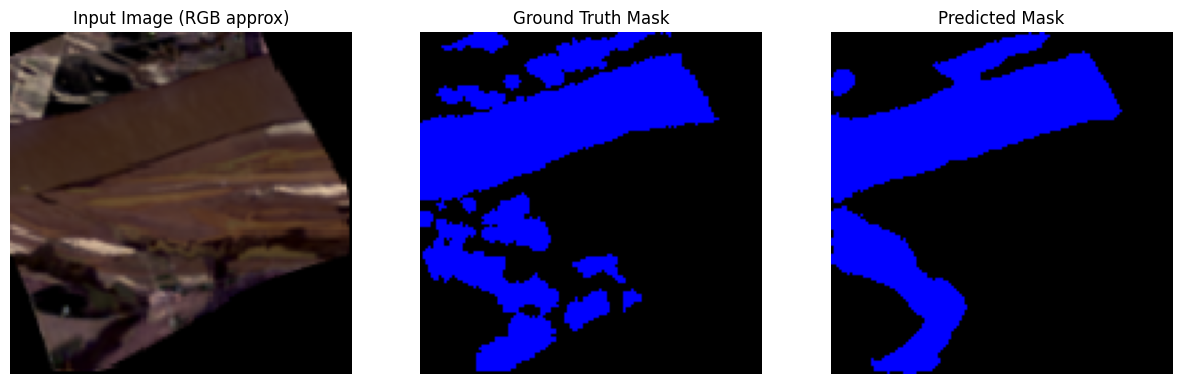

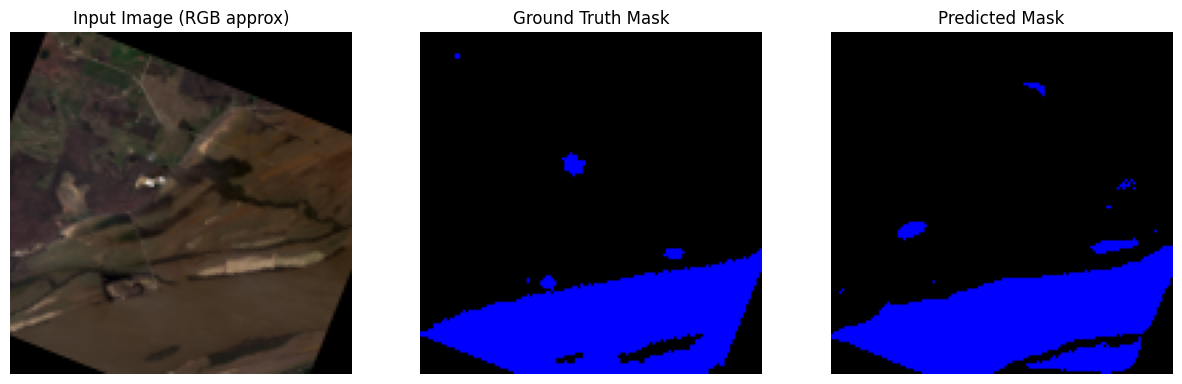

In [56]:
visualize_predictions_blue(nn_model, X_test, y_test, 5)



---





---



# The other Model with different loss and metrics function

In [60]:
# Uninstall current TensorFlow
!pip uninstall -y tensorflow

# Install a compatible TensorFlow version (e.g., 2.9.1)
# !pip install tensorflow==2.16.1
!pip install tensorflow

# Install segmentation_models with its dependencies
# !pip install segmentation-models
!pip install segmentation-models-tf

Found existing installation: tensorflow 2.16.1
Uninstalling tensorflow-2.16.1:
  Successfully uninstalled tensorflow-2.16.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 620.7/620.7 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 124.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.0/322.0 kB 30.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 131.5 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.25.8
    Uninstalling protobuf-4.25.8:
      Successfully uninstalled protobuf-4.25.8
  Attempting uninstall: ml_dtypes
    Found existing installation: ml-dtypes 0.3.2
    Uninstalling ml-dtypes-0.3.2:
      Successfully uninstalled ml-dtypes-0.3.2
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.16.2
    Uninstalling tensorboard-2.16.2:
      Successfully uninstalled tensorboard-2.16.2
ERROR: pip's dependency resolver does not currently take 

ERROR: Could not find a version that satisfies the requirement segmentation-models-tf (from versions: none)
ERROR: No matching distribution found for segmentation-models-tf


In [61]:
import tensorflow as tf
import segmentation_models as sm

AttributeError: module 'keras.utils' has no attribute 'generic_utils'

In [ ]:
print(tf.__version__)

In [ ]:
nn_model_2 = unet_model(input_size=(128, 128, 12))
nn_model_2.summary()

In [ ]:
LR = 1e-4
BATCH_SIZE = 32
EPOCHS = 100

### new parameters from sm library
loss = sm.losses.DiceLoss(class_weights=np.array(class_weights))
metrics = [sm.metrics.IOUScore(class_weights=np.array(class_weights)), 'val_accuracy']

In [ ]:
nn_model_2.compile(optimizer=Adam(learning_rate=LR), loss=loss,
                 metrics=metrics)

In [ ]:
nn_model_2_callbacks = [
    # ModelCheckpoint to save the best model based on validation IoU
    ModelCheckpoint('best_unet_model_2.keras', monitor='val_iou_score', save_best_only=True, mode='max', verbose=1),

    # ReduceLROnPlateau to reduce learning rate when validation IoU plateaus
    ReduceLROnPlateau(monitor='val_iou_score',
                      factor=0.2, # Factor by which the learning rate will be reduced. new_lr = lr * factor
                      patience=2, # Number of epochs with no improvement after which the learning rate will be reduced.
                      mode='max',
                      min_lr=0.0000001, # Lower bound on the learning rate (1e-7).
                      verbose=1)
]

In [ ]:
print("Model is Fitting...")

nn_model_2_fit = nn_model_2.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks = nn_model_2_callbacks
)

In [ ]:
plot_accuracy_curves(nn_model_2_fit)

In [ ]:
plot_losses_curves(nn_model_2_fit)

In [ ]:
evaluate_model(nn_model_2, X_test, y_test)

In [ ]:
visualize_predictions(nn_model_2, X_test, y_test)

In [ ]:
visualize_predictions_blue(nn_model_2, X_test, y_test, 5)